# Augmentaties definiëren

In [156]:
import albumentations as A
import os
from tensorflow.keras.utils import load_img, img_to_array
import scipy.ndimage as nd
from scipy.ndimage import gaussian_filter

In [157]:
def voeg_rafelruis_toe(img, ruis_std=0.02, drempel=0.6):
    if img.max() > 1.0:
        img = img / 255.0

    if img.ndim == 3:
        img = img.mean(axis=-1)

    binair = (img > drempel).astype(np.float32)

    # Subtiele rand met Sobel
    dx = nd.sobel(binair, axis=0)
    dy = nd.sobel(binair, axis=1)
    rand = np.hypot(dx, dy)

    # Jitter op kleine subset van rand
    jitter = np.random.normal(loc=0.0, scale=ruis_std, size=img.shape)
    jitter = gaussian_filter(jitter, sigma=0.3)
    masker = (rand > 0.1) & (np.random.rand(*img.shape) < 0.3)
    img = img + (jitter * masker)

    img = np.clip(img, 0.0, 1.0)
    binair = (img > drempel).astype(np.float32)

    return np.expand_dims(binair, axis=-1)


In [158]:
# Stap 3: Albumentations augmentatie
albumentations_transform = A.Compose([
    A.LongestMaxSize(128),
    # Vervanging voor ImageDataGenerator augmentaties:
    A.Rotate(limit=5),
    A.Affine(scale=(0.85, 1.15)),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=0),

    # Eerder gewenste vervormingen:
    A.OneOf([
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=1),
        A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)
    ], p=0.5),

    A.Resize(64, 64)
])


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\lenka\AppData\Local\Temp\ipykernel_4340\3089158211.py:13: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)


In [159]:
def load_dataset(dataset_dir):
    X, y = [], []
    label_map = {str(i): i for i in range(10)}
    
    for label_str in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_str)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            img_path = os.path.join(label_path, fname)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            X.append(img_to_array(img) / 255.0)
            y.append(label_map[label_str])
    
    return np.array(X), np.array(y)


# Testset inladen en aanvullen met augmentatie


In [160]:
from pathlib import Path
import numpy as np
from PIL import Image

# Testdata laden
X_test, y_test = load_dataset("synthetic_digits/test")

# Pad voor opslag
aug_test_dir = Path("augmented_test")
aug_test_dir.mkdir(parents=True, exist_ok=True)

# Augmenteren en opslaan
X_test_aug = []
for i, img in enumerate(X_test):
    # Pas augmentatie toe
    if albumentations_transform:
        img = albumentations_transform(image=img.astype(np.float32))['image']
    if voeg_rafelruis_toe:
        img = voeg_rafelruis_toe(img)

    # Opslaan als PNG
    save_img = img
    if save_img.dtype != np.uint8:
        save_img = np.clip(save_img, 0, 1)
        save_img = (save_img * 255).astype(np.uint8)

    if save_img.ndim == 2:
        pil_img = Image.fromarray(save_img, mode="L")
    elif save_img.shape[2] == 1:
        pil_img = Image.fromarray(save_img.squeeze(), mode="L")
    else:
        pil_img = Image.fromarray(save_img)

    pil_img.save(aug_test_dir / f"aug_test_{i}.png")
    X_test_aug.append(img)

X_test_aug = np.stack(X_test_aug)


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("models/final_model_full_train.keras")


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │        46,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,288 (1.59 MB)

 Trainable params: 138,762 (542.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 277,526 (1.06 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Accuracy: 0.9913
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        23
           4       0.96      1.00      0.98        23
           5       0.96      1.00      0.98        23
           6       1.00      1.00      1.00        23
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        23

    accuracy                           0.99       230
   macro avg       0.99      0.99      0.99       230
weighted avg       0.99      0.99      0.99       230



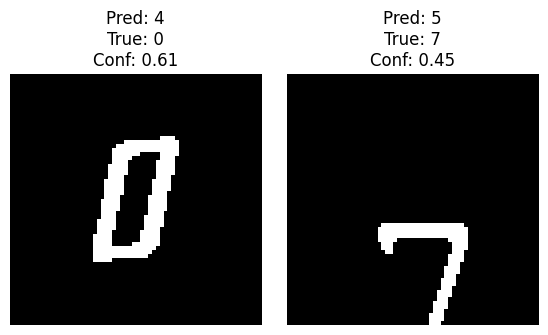

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Zorg dat y_test goed is
y_test_clean = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Voorspellingen
y_pred_probs = model.predict(X_test_aug)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluatie
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test_clean, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test_clean, y_pred))

# Vind indexen van fouten
misclassified_idxs = np.where(y_pred != y_test_clean)[0]

# Toon enkele foutieve voorspellingen met confidence
num_to_show = 10
plt.figure(figsize=(14, 6))
for i, idx in enumerate(misclassified_idxs[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    image = X_test_aug[idx]
    
    # Zorg dat het formaat klopt
    if image.ndim == 3 and image.shape[-1] == 1:
        image = image.squeeze(-1)
    elif image.ndim == 3 and image.shape[-1] == 3:
        image = image / 255.0

    confidence = np.max(y_pred_probs[idx])
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
    plt.title(f"Pred: {y_pred[idx]}\nTrue: {y_test_clean[idx]}\nConf: {confidence:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_clean, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9913


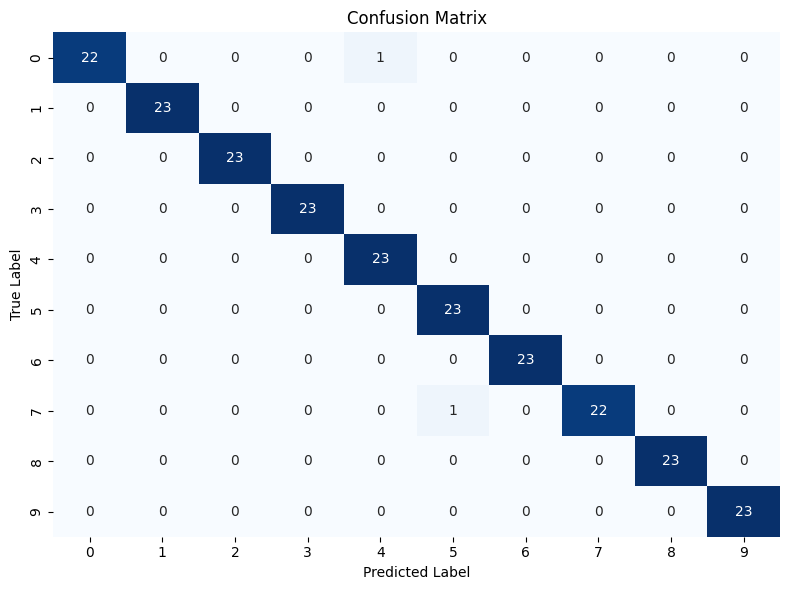

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Alleen voor mooie heatmap

# Confusion matrix berekenen
cm = confusion_matrix(y_test_clean, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
